# Analyse statistique de "Scythe"

## Présentation du jeu

Scythe est un jeu de société, qui tourne autour de la gestion de ressources, la stratégie et la guerre. L'objectif est d'avoir la plus grande fortune à la fin de la partie. Chaque joueur commence une partie avec deux plateaux individuels différents des autres. Le premier dit "Faction" qui est le peuple que dirigera le joueur, et le second est la plateau dit "Joueur" où sont caractérisées les différentes actions possibles à faire durant la partie. La partie se fini lorsqu'un joueur a placé 6 étoiles. Il y a 8 façons de placer une étoile. Et le décompte des points se fait selon : le nombre de pions étoile placé, le nombre de territoires controlés, et le nombre de lots de 2 ressources controlées.

## L'objectif de l'analyse

L'objectif est de comprendre qui, Faction et plateau Joueur, gagne le plus, quels sont les meilleurs combo, est-ce qu'une méthode de jeu semble plus fonctionner que d'autres. 

Dans l'étude, le numéro de joueur est celui de son rang. Ainsi le joueur 1 d'une partie représente le gagnant de la partie, le joueur 2 est le deuxième plus fortuné à la fin, etc...

## Récupération des parties

Les données proviennent de 9740 parties de Scythe sur le site Boardgame Arena. J'ai scrappé tout d'abord les 9740 liens (voir fichier Scrapping liens.py ), puis récupéré toutes les données de ces liens (voir fichier Scrapping données.py), en mettant de côté les parties annulées ou abandonnées. Ce qui nous fait une base de donnée composée de 8938 parties.


In [119]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("C:/Users/arthu/OneDrive/Bureau/Programmation/Python/Scrapping/BGA- Scythe/Extraction/Data_base_final.csv")

Premièrement nous allons analyser l'équilibre des factions.

Ainsi nous voulons donc tout d'abord regarder quel est le pourcentage de victoire pour chaque Faction sur les 8938 parties analysées.

Text(0.5, 1.0, 'Répartition des factions jouées par J1')

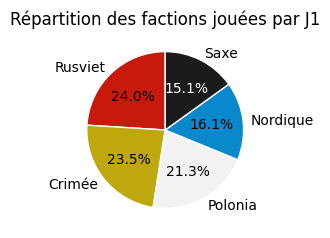

In [120]:
counts = df["J1 Faction"].value_counts()
labels = counts.index
valeurs = counts.values

couleurs_factions = {
    "Polonia" : "#F2F2F2",
    "Crimée" : "#bfa80d",
    "Rusviet" : "#c71a0a",
    "Nordique" : "#0a88cc",
    "Saxe" : "#191b1c"
}

colors = [couleurs_factions[label] for label in labels]

fig, ax = plt.subplots()

patches, texts, autotexts = ax.pie(
    valeurs,
    labels=labels,
    colors=colors,
    autopct="%1.1f%%",
    startangle=90,
    wedgeprops={"linewidth": 1, "edgecolor": "white"}
)

autotexts[list(labels).index("Saxe")].set_color("white") 

ax.set_title("Répartition des factions jouées par J1")

Avec ce premier tableau, nous pouvons voir que les Faction Russe et Crimée semblent être avantagées comparées aux Factions Saxe et Nordique. 

Nous pouvons formuler une hypothèse par l'absurde : "Le jeu est équilibré, donc chaque faction a une probabilité de victoire de 20% (100/5)."

///Attention/// Nous ne prenons comme paramètre que les gagnants des parties sélectionnées, peu importe leur niveau, le niveau des adversaires. 

Réalisons maintenant un test de Khi2 pour vérifier notre hypothèse. Le seuil de signification est de 2.5%.

In [121]:
from scipy.stats import chisquare

victoires = df["J1 Faction"].value_counts().sort_index()
expected = [1786]*5

chi2=0
for el in victoires :
    chi2 += ((el-(len(df)/5))**2)/(len(df)/5)

chi22 = chisquare(victoires, expected)
chi22 = chi22.pvalue

print("Chi2 : ", chi2)
print("2ème Chi2:", chi22/100, "%")


Chi2 :  310.70642201834863
2ème Chi2: 4.6403917857945225e-68 %


Le Chi2 ayant une valeur de 310, et une pvalue de moins de 1%. Nous pouvons donc conclure que le jeu n'est pas équilibré concernant les factions.

Nous allons maintenant nous intéresser au combo qui gagne le plus. En effet chaque joueur à une faction et un plateau "joueur". Lequel de ces combo est le plus puissant.

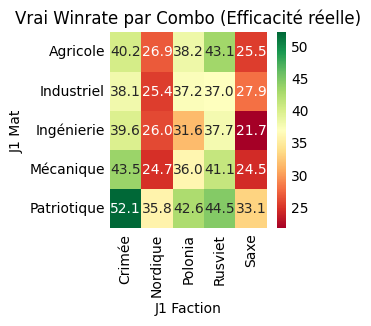

In [122]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

victoires = pd.crosstab(df["J1 Mat"], df["J1 Faction"])

total_joues = pd.DataFrame()
for i in range(1, 6):
    temp = df[[f"J{i} Mat", f"J{i} Faction"]].rename(columns={f"J{i} Mat": "Mat", f"J{i} Faction": "Faction"})
    total_joues = pd.concat([total_joues, temp])

cpts_total = pd.crosstab(total_joues["Mat"], total_joues["Faction"])

winrate = (victoires / cpts_total) * 100

sns.heatmap(winrate, annot=True, fmt=".1f", cmap="RdYlGn")
plt.title("Vrai Winrate par Combo (Efficacité réelle)")
plt.show()

Nous pouvons donc voir que le combo "gagnant" est la Faction "Crimée" combiné au plateau Joueur "Patriotique" avec un winrate de 52,1%. Ce tableau vient confirmer l'analyse faite précédemment, nous apercevons clairement des meilleurs résultats avec les combos comprenant les factions Rusviet et Crimée.

Finalement nous allons pouvoir analyser, de quelle manière les joueurs gagnent leur parties, c'est à dire de quelle manière les 6 étoiles sont placées par les Joueurs 1 (joueur gagnant).


In [123]:
import plotly.graph_objects as go

cols = df.columns[68 : 68 + 9 * 5 : 5]

categories = []

for el in cols : 
    categories.append(el[3:])

factions = df["J1 Faction"].dropna().unique()

etoiles = {}

for faction in factions:
    etoiles[faction] = []

for cat_etoile in cols :
    for faction in factions :
            masque = df["J1 Faction"] == faction
            etoiles[faction].append((df.loc[df["J1 Faction"] == faction, cat_etoile].sum())/masque.sum())

for faction in etoiles:
    etoiles[faction].append(etoiles[faction][0])

categories.append(categories[0])

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=etoiles["Crimée"],
      theta=categories,
      name='Crimée',
      line=dict(color='Yellow')
))

fig.add_trace(go.Scatterpolar(
      r=etoiles["Polonia"],
      theta=categories,
      name='Polonia',
      line=dict(color='Grey')
))

fig.add_trace(go.Scatterpolar(
      r=etoiles["Rusviet"],
      theta=categories,
      name='Rusviet',
      line=dict(color='Red')
))

fig.add_trace(go.Scatterpolar(
      r=etoiles["Nordique"],
      theta=categories,
      name='Nordique',
      line=dict(color='Blue')
))

fig.add_trace(go.Scatterpolar(
      r=etoiles["Saxe"],
      theta=categories,
      name='Saxe',
      line=dict(color='black')
))

fig.update_layout(
     title="Répartition moyenne des étoiles par faction",
      polar=dict(
      radialaxis=dict(
      visible=True,
      )),
  showlegend=True
)



Tout d'abord afin d'expliquer certains résultat, il peut y avoir 2 étoiles de combat posé, c'est pourquoi il n'est pas étonnant de voir des proportions dépasser 1. De plus chaque faction possède une capacité "spéciale" et celle de la Saxe (Noir) est de pouvoir poser autant d'étoiles de combat et d'objectif (2 cartes objectifs distribué à chaque joueur au début du jeu). Ainsi la faction saxe peut se rapprocher de 1 sur la ligne "Etoile objectif".

Nous pouvons donc observer qu'une certaine stratégie se dessine, puisque 6 étoiles sortent du lot (en comptant 2 pour les étoiles de combats). En effet, les étoiles de combat, objectif, ouvrier, recrue, et méchas sont bien représentées avec des proportions supérieures à 0,6%. Contrairement à l'étoile popularité max représentée seulement à 0,1 pour la faction Polonia puis en dessous de 0,05 pour les autres factions. De même pour les batiments, une proportion qui dépasse 0,5 pour la faction Polonia mais qui reste minime pour les autres.

Maintenant nous allons nous pencher sur les points, puisque parfois ce n'est pas la personne qui pose ses 6 étoiles qui gagne la partie. 

Comment se déroule le décompte des points dans scythe ? 
Chaque joueur à la fin du jeu est dans une des 3 catégories de popularité, plus il est populaire plus il multiplie les pécules qu'il gagne selon les étoiles, les paires pions ressources restants et les territoires controlés. Et finalement quelque points en plus avec des combinaisons de placement de batiments (Tuile Bonus).

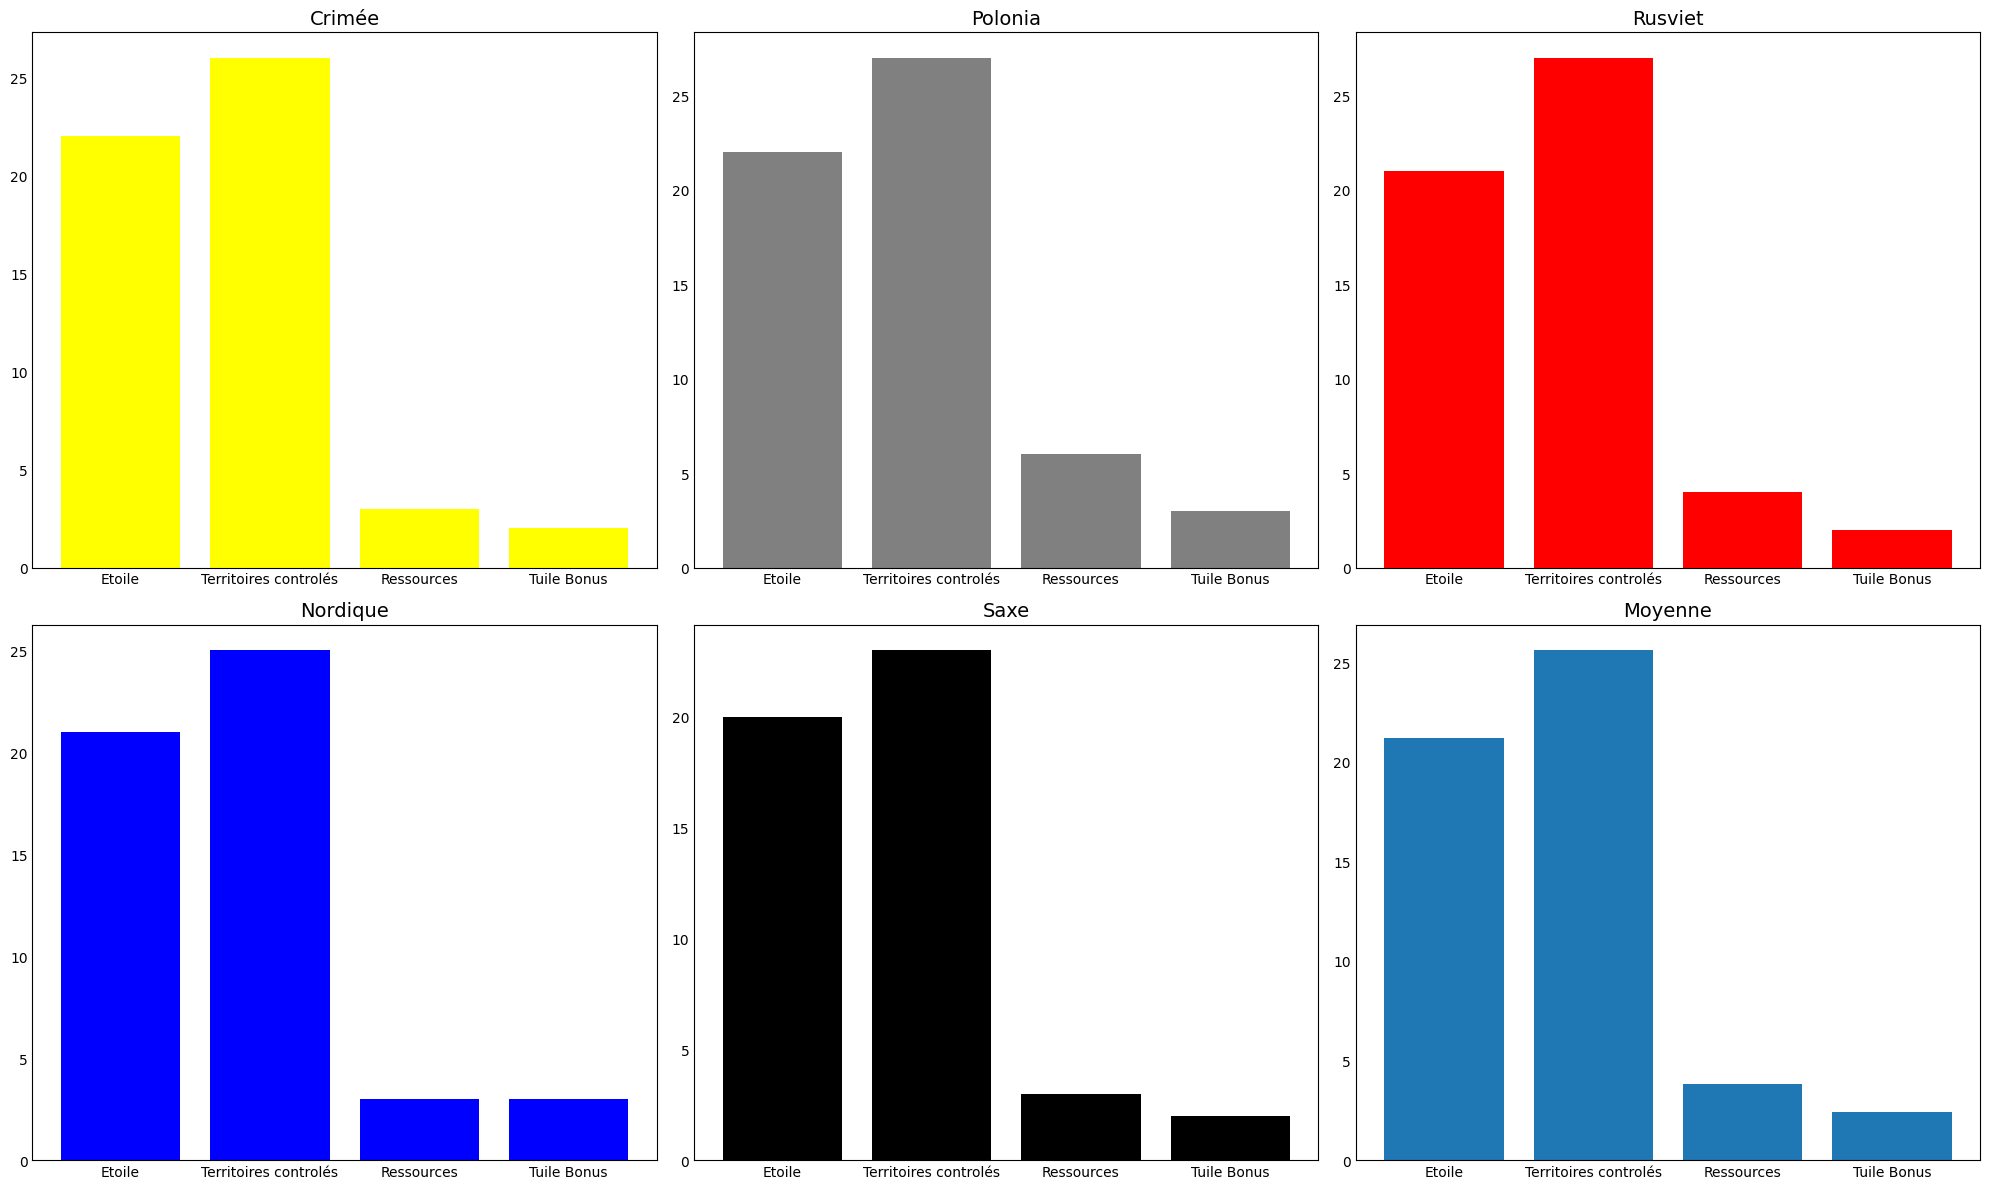

In [124]:
cat_points = ["Etoile", "Territoires controlés", "Ressources", "Tuile Bonus"]
colonne_points = ["J1 Pts étoiles", "J1 Pts territoires","J1 Pts ressources","J1 Pts tuile bonus"]

points = {}

for faction in factions :
    points[faction] = []
    for el in colonne_points :
        mask = df["J1 Faction"] == faction
        points[faction].append(int((df.loc[df["J1 Faction"] == faction, el].sum())/mask.sum()))

points["Moyenne"] = []

for x in range(4):
    y = 0
    for faction in factions:
        y+= points[faction][x]
    points["Moyenne"].append((y/5))

fig, axs = plt.subplots(2, 3, figsize=(20,12))

axs[0, 0].bar(cat_points, points["Crimée"], color="Yellow")
axs[0, 0].set_title("Crimée", fontsize=14)
axs[0, 1].bar(cat_points, points["Polonia"], color="grey")
axs[0, 1].set_title("Polonia", fontsize=14)
axs[0, 2].bar(cat_points, points["Rusviet"], color="Red")
axs[0, 2].set_title("Rusviet", fontsize=14)
axs[1, 0].bar(cat_points, points["Nordique"], color="blue")
axs[1, 0].set_title("Nordique", fontsize=14)
axs[1, 1].bar(cat_points, points["Saxe"], color="black")
axs[1, 1].set_title("Saxe", fontsize=14)
axs[1, 2].bar(cat_points, points["Moyenne"])
axs[1, 2].set_title("Moyenne", fontsize=14)

plt.tight_layout()


Nous pouvons donc voir une similitude entre les différentes répartitions de points moyens par factions. Il semble donc important de controler beaucoup de territoires à la fin de partie pour gagner. 

## Conclusion

Nous avons donc pu analyser et montrer que le jeu Scythe n'est pas équilibré. Il existe 2 factions supérieurs aux autres "Rusviet" et "Crimée". Certains combos sont plus puissant et sont donc à prioriser lors de partie de tournoi (choix des factions et des plateaux joueurs). 

De plus, la stratégie la plus optimale est de viser les 6 étoiles suivante : 2 x combats, 1 x objectif, 1 x recrue, 1 x méchas, 1 x ouvrier.

Finalement, la majeure partie des points provient du controle de territoire, il est donc important de s'étendre largement lorsque la fin de la partie approche.